# Prediction of Renewable Power Loss caused by Feed-in Management Events

The goal of this project is a model that predicts lost power for the next control interval(s) in dependence of various parameters in the past. This is useful for energy traders, grid operators as well as consumers who participate in Demand-Side-Managment. In the present notebook test and validation metrics of the various models are shown and compared. A selection of the best performing model will end this project. 

**Business Context: keeping the energy grid stable**<br>
In recent years the expansion of renewable generation capacity has been proceeding due to efforts being made to transition to low carbon energy systems. This development causes a variety of challenges including the intermittent availability of renewable generation, such as wind energy, as well as the need for construction of according transmission infrastructure. The resulting mismatch between transmission and generation infrastructure causes congestion in the transmission grid. Germanys electricity market relies on feed-in managment to cure short-time congestion when grids cannot absorb all intermittent generation. The term feed-in management refers to the curtailment of power that is fed into the power grid in dependence of the power that is actually used by connected consumers or is being transferred on to other grid areas. A prediction of Feed-In Management Orders could aid with Demand Side Mangement Scheduling, making use of the otherwise lost renewable energy. 


<img src="./figures/overview_DMS_FIM.png" alt="grid_areas_germany" width="600" />



### Project Organisation

The project is organized as seen below: 

- [FeedInMngmt_presentation.pdf](FeedInMngmt_presentation.pdf): Presentation of the project including additional explanation about the feed-in managment sitatuion.
- [FeedInMngmt_EDA.ipynb](FeedInMngmt_EDA.ipynb): Loading and pre-processing feed-in managment data as well as weather data, price data and energy consumption data. Followed by an exploration of the given data as well as an investigation of correlating behavior of various time series (e.g., the influence of wind on feed in management events). This document ends with a ranking and selection of features by their importance.  
- [FeedInMngmt_Base_Models.ipynb](FeedInMngmt_Base_Models.ipynb): Creation and elaboration of train-validation-test split as well as design of two naive baseline models: the Shift model (e.g., the next timestep equals the last time step) and an  Exponential Smoothing model (e.g., next timestep equals the moving average over the last X hours). In addition, functions to evaluate the test results are described in this document.  
- [FeedInMngmt_Prophet.ipynb](FeedInMngmt_Prophet.ipynb): Implementation and evaluation of a FB Prophet Model for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_LSTM_NN.ipynb](FeedInMngmt_LSTM_NN.ipynb): Implementation and evaluation of a Long-Short-Term-Memory Recurrent Neural Network for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_LSTM_NN_PeepHole.ipynb](FeedInMngmt_LSTM_NN_PeepHole.ipynb): Implementation and evaluation of a Long-Short-Term-Memory Recurrent Neural Network with peephole connections for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_Results.ipynb](FeedInMngmt_Results.ipynb): Evaluation of the different models based on the chosen test metrics and application on an example use case.
- [FeedInMngmt_Results_Visualization.ipynb](FeedInMngmt_Results_Visualization.ipynb): Interactive Visualization of the predictions and actual values for every model.

# Environment Set-Up

In [1]:
reset -fs

In [2]:
# Importing the most important modules and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
from datetime import datetime
import pickle
from scipy.integrate import simps

import plotly.offline as pyo
import plotly.graph_objects as go

# For Data Mining and data export
import glob

## Global Variables and Settings

In [3]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

color_1 = 'goldenrod'
color_2 = 'darkred'

## Definition of Functions

In [4]:
def split_at(string, seperator, at_n, return_after=True):
    '''
    helper function to sperate file path into name
    '''
    words = string.split(seperator)
    if return_after: 
        return seperator.join(words[at_n:])
    else: 
        return seperator.join(words[:at_n])

def clean_brackets(df_result): 
    '''
    Explaination: Working with LSTMs, the error metrics are sometimes encapsulated into square brackets. 
    Return: dataframe without square brackets. 
    '''
    for colm in df_result.columns: 
        if df_result[colm].dtype != np.number:
            df_result[colm] = [float(x.replace("[", "").replace("]", "")) for x in df_result[colm]]
    return df_result

In [5]:
def get_erros(metric = 'MAPE', folder='Test Errors'):
    '''
    Reason: Error Metrics are saved into .csv files, one file per model including multiple error metrics
    metric: ['RMSE', 'R2', 'MAE', 'MAPE']
    folder: ['Test Errors', 'Validation Errors']
    Return: pd.DataFrame with specified Error Metric for all .csvs in specified folder
    '''
    file_start = '_'.join(folder.split(' ')).lower()
    errors = pd.DataFrame()
    for file in glob.glob(f'{folder}/{file_start}*.csv'): 
        # Preperation of column Name
        name = file
        name = split_at(file, '_', 2, return_after=True)
        name = split_at(name, '.', 1, return_after=False)
        name = name.replace('_', ' ')
        
        #loading raw data
        raw_table = pd.read_csv(file, header=0, usecols=[metric])
        
        #concatenate data to the right 
        raw_table.rename(columns={metric:name}, inplace=True)
        raw_table.index += 1
        errors = pd.concat([errors, raw_table], axis=1, ignore_index = False)
    errors.index.name = 'Step'
    errors = clean_brackets(errors).T
    errors = errors.sort_index()
    
    return errors

In [6]:
def plot_static_metrics(df_results, metric='MAPE', val_or_test='Test'): 
    df_results = df_results.T
    ###### COLOR SETTINGS ##### evenly_spaced_colors for len(colm)
    colors=['olive', 'goldenrod', 'darkred', 'grey', 'midnightblue','crimson', 'forestgreen','darkmagenta'] #'sandybrown', 'sienna'
    if df_results.shape[1] > len(colors): 
        evenly_spaced_interval = np.linspace(0, 1, len(df_results.columns))
        colors = [cm.jet(x) for x in evenly_spaced_interval]
    ###### DATA PLOTTING ###### 
    fig, ax = plt.subplots(figsize=(18,4))               
    for colm, c in zip(df_results.columns, colors):
        plt.plot(df_results[colm], label=colm ,color=c, lw=4)

        
    ###### PLOT SETTINGS #######
    plt.title(f'{metric} for each predicted timestep into the future ({val_or_test} set)', fontsize=20)
    plt.xlabel('STEPS INTO THE FUTURE', fontsize=14)
    plt.ylabel(f'{metric}', fontsize=14)
    plt.xlim(1, 19)
    plt.legend(loc='upper left', fontsize=14,  bbox_to_anchor=(1.01, 1))

    ###### OUTPUT #######
    #plt.savefig(f'figures/results_{metric}_{val_or_test}.png', bbox_inches='tight', transparent=True)
    plt.show;

In [7]:
def plot_interactive_metrics(): 
    names = list(MAPE_val.columns)
    # colors, if less then defined, create evenly spaced colors
    colors = ['olive', 'goldenrod', 'darkred', 'grey', 'midnightblue','crimson', 'forestgreen','darkmagenta']
    if len(names) > len(colors): 
        evenly_spaced_interval = np.linspace(0, 1, len(names))
        colors = [cm.jet(x) for x in evenly_spaced_interval]

    # plotly setup]
    fig = go.Figure()

    # Add one ore more traces
    for indx in range(len(names)):
        fig.add_traces(go.Line(y=MAPE_test[names[indx]], 
                               name=names[indx], 
                               fillcolor='blue', 
                               mode='lines',
                               line=dict(color=colors[indx])))

    # construct menus
    updatemenus = [{'buttons': [{'method': 'update',
                                 'label': 'MAPE Test',
                                 'args': [{'y': [MAPE_test[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'MAPE Validation',
                                 'args': [{'y': [MAPE_val[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'RMSE Test',
                                 'args': [{'y': [RMSE_test[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'RMSE Validation',
                                 'args': [{'y': [RMSE_val[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'R2 Test',
                                 'args': [{'y': [R2_test[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'R2 Validation',
                                 'args': [{'y': [R2_val[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'MAE Test',
                                 'args': [{'y': [MAE_test[names[indx]] for indx in range(len(names))]},]
                                  },
                                {'method': 'update',
                                 'label': 'MAE Validation',
                                 'args': [{'y': [MAE_val[names[indx]] for indx in range(len(names))]},]}],
                    'direction': 'down',
                    'showactive': True}]

    # update layout with buttons, and show the figure
    # Code belowe is commented out since the interactive plot is not shown via 
    fig.update_layout(updatemenus=updatemenus)
    fig.show()

# Visualisation of Error Metrics 

In [8]:
# Data Preperation 
metric ='MAPE'
MAPE_test = get_erros(metric = metric, folder='Test Errors').round(3).T
MAPE_val = get_erros(metric = metric, folder='Validation Errors').round(3).T
metric ='RMSE'
RMSE_test = get_erros(metric = metric, folder='Test Errors').round(3).T
RMSE_val = get_erros(metric = metric, folder='Validation Errors').round(3).T
metric ='R2'
R2_test = get_erros(metric = metric, folder='Test Errors').round(3).T
R2_val = get_erros(metric = metric, folder='Validation Errors').round(3).T
metric ='MAE'
MAE_test = get_erros(metric = metric, folder='Test Errors').round(3).T
MAE_val = get_erros(metric = metric, folder='Validation Errors').round(3).T

For a first comparison of error metrics on the validation and test set, the code below executes an interactive plot (as demonstrated below) within the current notebook. 
```Python
plot_interactive_metrics()
```


<img src="./figures/visualization_metrics_demo.gif" alt="visualization_demo"/>

In [9]:
#plot_interactive_metrics()

### Static Plots incl. Error Tables for deeper Investigation

For an indepth analysis, the error metrics can be inspected using the follwoing function. 

Step,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
exponential smoothing model,0.124,0.157,0.197,0.233,0.267,0.301,0.336,0.370,0.399,0.426,0.451,0.473,0.499,0.525,0.546,0.567,0.587,0.604
fbprophet,0.112,0.154,0.186,0.223,0.254,0.283,0.314,0.346,0.373,0.397,0.418,0.438,0.460,0.484,0.506,0.526,0.544,0.561
multivariate lstmNN,0.380,0.417,0.456,0.437,0.497,0.480,0.452,0.509,0.503,0.483,0.476,0.504,0.527,0.482,0.479,0.528,0.470,0.575
multivariate lstmNN PeepHole,0.381,0.404,0.467,0.455,0.440,0.534,0.503,0.457,0.498,0.463,0.479,0.503,0.575,0.519,0.492,0.487,0.536,0.518
naive model,0.112,0.155,0.190,0.230,0.262,0.296,0.329,0.366,0.395,0.422,0.448,0.470,0.494,0.520,0.543,0.565,0.585,0.604
univariate lstmNN,0.133,0.117,0.138,0.137,0.173,0.145,0.197,0.233,0.357,0.248,0.355,0.266,0.342,0.434,0.486,0.618,0.354,0.441
univariate lstmNN PeepHole,0.124,0.113,0.144,0.147,0.215,0.149,0.219,0.166,0.196,0.330,0.223,0.305,0.348,0.410,0.388,0.473,0.318,0.413


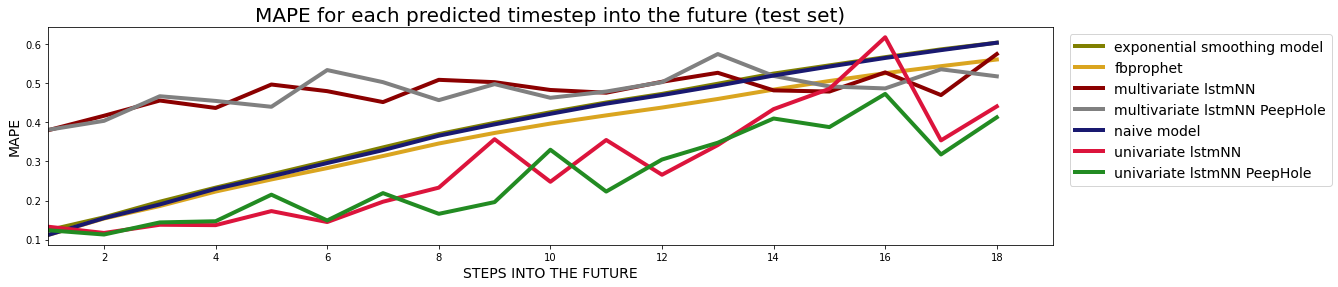

In [10]:
# MAPE in Test Set
plot_static_metrics(MAPE_test.T,  metric='MAPE', val_or_test='test')
MAPE_test.T

# Interactive Visualization of predictions

Execution of the code below will start an interactive plot (as demonstrated below) in the default browser. On the right 3 dropdown selectors enable the user to choose of which model for which dataset and for which timestep the predictions shall be shown. To stop the interactive plot the kernel needs to be restarted.

```Python
! bokeh serve --show visualization.py
```

<img src="./figures/visualization_predictions_demo.gif" alt="visualization_demo"/>

In [11]:
#! bokeh serve --show visualization.py

# Usecase - Power to Gas

The data in the capstone project comes from the windfwarm [Twistringen](https://www.thewindpower.net/windfarm_de_23912_twistringen.php) in the south-east of Bremen. The windfwarm consists of 13 wind turbines with a total installed capacity of **`22.8 MW`**. With this knowledge the normed power loss values of the forecasts can be transformed into a simple hands-on use case.

#### Introduction:
In the example use case that will be evaluated the otherwise lost power that the best model is able to forecast is supposed to be used to produce hydrogen, which can then be used as fuel for fuel cell buses, which have already been successfully deployed in cities like Hamburg.

<img src="./figures/overview_DMS_FIM.png" alt="grid_areas_germany" width="600" />

#### Assumptions:
- A 100% efficient [electrolyser](http://www.renewableenergyfocus.com/view/3157/hydrogen-production-from-renewables/) requires 39 kWh to produce 1 kg of hydrogen. The devices today require as much as **`48 kWh/kg`**. 
- A [fuel cell bus](https://infoportal.mobil.nrw/technik/busse-mit-elektrischem-antrieb/brennstoffzellen-linienbus.html) with a pressure tank containing around **`40 kg`** of hydrogen (storage pressure 350 bar) can be refuelled in around seven minutes. With one tank filling, the bus can travel about **`300 km`** - 350 km.
- Ramp up times and logistics are not taken into account.

#### Approach:
- To keep the example simple only the best-performing model will be evaluated, which is the **`univariate LSTM-Model with peephole connections`**.
- It is calculated how much otherwise lost power could have been used for hydrogen production, if the forecast would have been done **`10 minutes`**, **`1.5 hours`** and **`3 hours`** ahead for the 10-day test interval from **`20/04/2019 06:00 to 29/04/2019 06:00`**.
- The results are converted into the mileage that a fuel cell bus could otherwise have achieved.

In [12]:
# loading predictions and observed values of best performing model on test data
df_uni_lstm_peephole_test_pred = pd.read_csv("./Results/uni_lstm_peephole_test_predictions.csv")
df_uni_lstm_peephole_test_test = pd.read_csv("./Results/uni_lstm_peephole_test_values.csv")
# concatenating the columns that will be analyzed
combined_df = pd.concat([df_uni_lstm_peephole_test_pred["y_test_pred Step 1"],
                         df_uni_lstm_peephole_test_pred["y_test_pred Step 9"],
                         df_uni_lstm_peephole_test_pred["y_test_pred Step 18"], 
                         df_uni_lstm_peephole_test_test["y_test_observed Step 1"],
                         df_uni_lstm_peephole_test_test["y_test_observed Step 9"],
                         df_uni_lstm_peephole_test_test["y_test_observed Step 18"]], axis=1)

# grabbing the time series that need to be integrated
y1_forecasted = combined_df[['y_test_pred Step 1','y_test_observed Step 1']].min(axis=1)
y9_forecasted = combined_df[['y_test_pred Step 9','y_test_observed Step 9']].min(axis=1)
y18_forecasted = combined_df[['y_test_pred Step 18','y_test_observed Step 18']].min(axis=1)
y1_actual = combined_df['y_test_observed Step 1']
y9_actual = combined_df['y_test_observed Step 9']
y18_actual = combined_df['y_test_observed Step 18']

# calculating the power loss that could have been predicted for the 10-day test set, if forecasts
# were taken 10 minutes, 1.5 hours or 3 hours ahead
accumulated_predicted_loss1 = round((22.8 * simps(y1_forecasted, dx=1/6)),1)
accumulated_predicted_loss9 = round((22.8 * simps(y9_forecasted, dx=1/6)),1)
accumulated_predicted_loss18 = round((22.8 * simps(y18_forecasted, dx=1/6)),1)
accumulated_predicted_loss = [accumulated_predicted_loss1,accumulated_predicted_loss9,accumulated_predicted_loss18]

# calculating the actual power loss for the 10-day test set
accumulated_actual_loss1 = int((22.8 * simps(y1_actual, dx=1/6)))
accumulated_actual_loss9 = int((22.8 * simps(y9_actual, dx=1/6)))
accumulated_actual_loss18 = int((22.8 * simps(y18_actual, dx=1/6)))
accumulated_actual_loss = [accumulated_actual_loss1,accumulated_actual_loss9,accumulated_actual_loss18]

# calculating the percentage of power loss that could have been predicted
percentage_predicted1 = round((accumulated_predicted_loss1 / accumulated_actual_loss1)*100,1)
percentage_predicted9 = round((accumulated_predicted_loss9 / accumulated_actual_loss9)*100,1)
percentage_predicted18 = round((accumulated_predicted_loss18 / accumulated_actual_loss18)*100,1)
percentage_predicted = [percentage_predicted1,percentage_predicted9,percentage_predicted18]

# converting the saved power into the mileage that a fuel cell bus could otherwise have achieved
buskilometers1 = int((accumulated_predicted_loss1 / (48/1000) * (300/40)))
buskilometers9 = int((accumulated_predicted_loss9 / (48/1000) * (300/40)))
buskilometers18 = int((accumulated_predicted_loss18 / (48/1000) * (300/40)))
buskliometers = [buskilometers1,buskilometers9,buskilometers18]

data_tuples = list(zip(accumulated_actual_loss,accumulated_predicted_loss,percentage_predicted,buskliometers))
results = pd.DataFrame(data_tuples, columns=['Lost Power in MWh','Lost Power (forecasted) in MWh'
                                             ,'Percentage in %','Potential Mileage of Fuel Cell Bus in km'],
                       index = ["Prediction 10 minutes ahead","Prediction 1.5 hours ahead","Prediction 3 hours ahead"])
results

,Lost Power in MWh,Lost Power (forecasted) in MWh,Percentage in %,Potential Mileage of Fuel Cell Bus in km
Prediction 10 minutes ahead,503,495.0,98.4,77343
Prediction 1.5 hours ahead,503,451.9,89.8,70609
Prediction 3 hours ahead,503,322.3,64.1,50359


#### Results:
- The short term forecasts might not be realistically applicable for the scheduling of hydrogen production due to logistics and other concerns, but even for a 3 hours ahead forecast the accumulated power for over **`50.000 km`** of potential fuel cell bus mileage could have been saved over the short amount of 10 days.

# Future Work

### APIs for live predictions

For live predictions of Feed-In Management loss, GFS Data, Feed-In Management Data as well as Price and Consumption data need to be received via an application programming interface (API). 
Services to consider include: 
- [eex Market API](https://www.eex.com/en/market-data/eex-group-datasource/api)
- [SMARD Strommarktdaten](https://www.smard.de/en/downloadcenter/download-market-data)
- [OpenWeather API](https://openweathermap.org/api)
- [climacell Weather Data](https://www.climacell.co/)

### Interpolation of inconsistent / artificial data April/Mai 2019

In the Exploratory Data Analysis, inconsistent / artificial data was observered for part of April/Mai 2019. In the current approach, the data was cut of at `2019-04-30 06:00:00` to avoid the model being trained on artificial data. An interpolation of the data gap could be done using a Standard Week or even a prediction model for the seasonal data. 

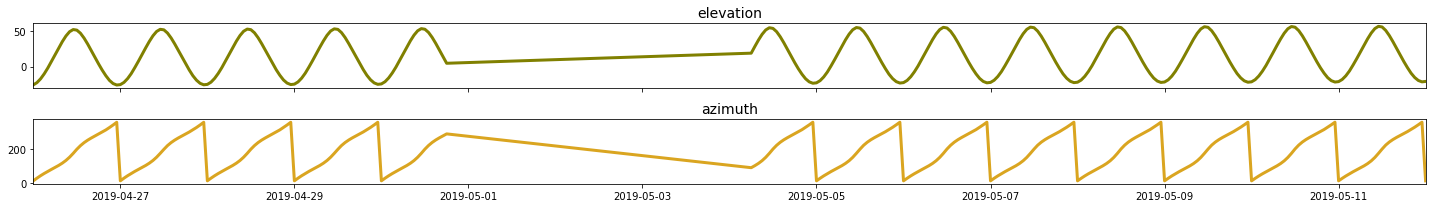

In [13]:
# reading in the feature dataframe
with open('./data/griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df = u.load()
    
#### DATA SELECTION ####
start_index = pd.to_datetime("2019-04-26 00:00:00 +00:00")
end_index = pd.to_datetime("2019-05-12 00:00:00 +00:00")
f_to_plot = ['elevation', 'azimuth']

#reduced timeframe
df_reduced = df[(df.index <= end_index) & (df.index >= start_index)]

#### PLOTTING #####
color=iter(['olive', 'goldenrod', 'darkred', 'sandybrown', 'sienna', 'grey'])
fig, axs = plt.subplots(len(f_to_plot), sharex=True, figsize=(20,len(f_to_plot)*1.5), facecolor='w')
for f, axes in zip(f_to_plot, axs): 
    c=next(color, 'goldenrod')
    axes.plot(df_reduced[f], color=c, lw=3)
    axes.set_title(f, fontsize=14)
    axes.set_xlim(left=start_index, right=end_index)
fig.tight_layout()
plt.show(fig);

### Forecast of GFS Data for Feed-In Mgmt predictions >1 timestep

Currently the implemented models predict the Feed-In Management loss based on the assumption of a perfect forecast for the GFS Data. In reality either an API or a seasonal model should be used to gather this information.

# End Note

This is the final project at the Data Science Bootcamp **[@neuefische](www.neuefische.de)**. This project has been developed in the fall of 2020 by Tjade Appel ([LinkedIn](www.linkedin.com/in/tjade-appel) / [GitHub](https://github.com/tjade27)) and Jonas Jaenicke ([LinkedIn](www.linkedin.com/in/jonasjaenicke) / [GitHub](https://github.com/JonJae)). Please feel free to contact us.  

In [14]:
print('This cell was last run on: ')
print(datetime.now())

This cell was last run on: 
2020-11-24 19:16:35.086040
